In [27]:
!python -V

Python 3.8.10


In [28]:
import pandas as pd

In [29]:
import pickle

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [32]:
df = pd.read_parquet('./data/green_tripdata_2022-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [33]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.50,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.50,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.50,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.00,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.00,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62490,2,2022-01-31 23:25:00,2022-01-31 23:33:00,None,NaN,40,65,NaN,1.40,8.38,...,0.0,1.93,0.0,None,0.3,10.61,NaN,NaN,NaN,8.000000
62491,2,2022-01-31 23:52:00,2022-02-01 00:10:00,None,NaN,36,61,NaN,2.97,14.92,...,0.0,0.00,0.0,None,0.3,15.22,NaN,NaN,NaN,18.000000
62492,2,2022-01-31 23:17:00,2022-01-31 23:36:00,None,NaN,75,167,NaN,3.70,16.26,...,0.0,0.00,0.0,None,0.3,16.56,NaN,NaN,NaN,19.000000
62493,2,2022-01-31 23:45:00,2022-01-31 23:55:00,None,NaN,116,166,NaN,1.88,9.48,...,0.0,2.17,0.0,None,0.3,11.95,NaN,NaN,NaN,10.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59603 entries, 0 to 62494
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               59603 non-null  int64         
 1   lpep_pickup_datetime   59603 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  59603 non-null  datetime64[ns]
 3   store_and_fwd_flag     53367 non-null  object        
 4   RatecodeID             53367 non-null  float64       
 5   PULocationID           59603 non-null  object        
 6   DOLocationID           59603 non-null  object        
 7   passenger_count        53367 non-null  float64       
 8   trip_distance          59603 non-null  float64       
 9   fare_amount            59603 non-null  float64       
 10  extra                  59603 non-null  float64       
 11  mta_tax                59603 non-null  float64       
 12  tip_amount             59603 non-null  float64       
 13  tolls_

In [35]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.7357935521496834

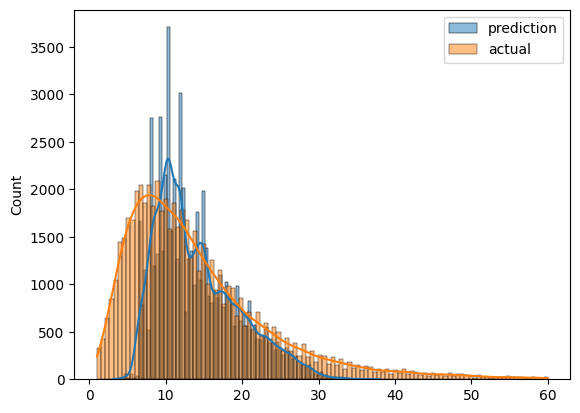

In [36]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

plt.legend()

In [37]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [38]:
df_train = read_dataframe('./data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2022-02.parquet')

In [39]:
len(df_train), len(df_val)

(59603, 66097)

In [40]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [41]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [42]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.928931234129946

In [44]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [45]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.938195476223203